# Demo: Synth Riders Guide Note Generator

Take your audio files and make some JSON note timing positions to use with the [Synth Riders Beatmap Editor](https://store.steampowered.com/app/1121930/Synth_Riders_Beatmap_Editor/)!

**What this will do:**

*   Generate kinda centered guide notes where notes are detected in the audio.
*   Autodetect the most common BPM and figure out what BPM is doing over time.
*   Place notes on variable BPM tracks, no warping required.

**What this will *not* do:**

*   Make a whole beatmap for you. Positioning, rails, walls, that's all between you and the editor.
*   Generate exactly the notes you want. Some of these might be a little bit off, there might be too many of them, some might be missing. You can fix some of this with preprocessing, but don't rely on it to do everything for you.
*   Give good results with every type of audio, especially very complex audio.

You will still need to do some manual labor in the editor to actually make a map. If you have a stable BPM, a vision, and are good with the editor, this is probably unnecessary.

Shoutout to Marinus for his help on deconstructing the JSON time formatting, and Gohidas's [really excellent helper tool](https://github.com/adosikas/synth_mapping_helper) for figuring out a ton of the formatting and making this a lot easier.


# Let's map the beat!

First, some setup:

In [1]:
from synth_auto_map.beat_finder import *

## Load Your Audio

Update the code below to use your file path. Either the usual .ogg or .wav files are fine.

Have the BPM and offset already figured out? Awesome! You can change those below as well. Otherwise, just keep the defaults.

In [2]:
file_name = "Vivaldi_L'inverno_Allegro_Non_Molto.ogg"
bpm = None  # Add the BPM here if you know it
offset = None  # Update this to offset in milliseconds if you have it

Run the code below to load your file and generate the beatmap. Librosa might take a bit to process the file, don't worry!

In [3]:
music_beats = SoundConversion(file_name, bpm=bpm, offset=offset)
music_beats.generate_beatmap("generated_beatmap.json")

## We have a beatmap!

You should see something in this folder called generated_beatmap.json now.

To use this, set up your beatmap in the Synth Riders Beatmap Editor, and update the BPM. Then, open up the JSON file in your favorite text editor, copy the whole thing and paste it into your beatmap. Congratulations! You have a very boring beatmap with guide notes.

## Estimating BPM

We can check out the BPM over time and get the most common detected BPM (this is the default that's used if you don't specify a BPM, so you can use it as a starting point.) Weird rhythm/quiet sections might make this look like variable BPM even if it isn't, so use your judgement.

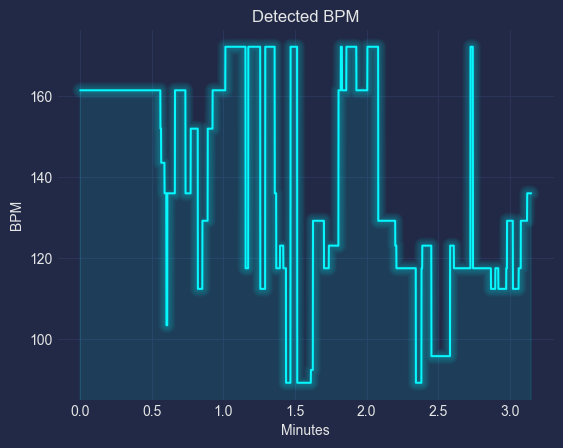

161.4990234375

In [4]:
music_beats.tempos(chart=True)

If that chart has a few consistent BPM sections that you'd like to map separately, we can find those track onset timings and associated BPM values. This will generate a BPM_onsets.csv file as well.

In [5]:
bpm_df = music_beats.tempo_breakdown()
print(bpm_df)
bpm_df.to_csv("BPM_onsets.csv")

           BPM        Time
0   161.499023    0.000000
1   151.999081   33.576054
2   143.554688   33.877914
3   135.999178   35.294331
4   103.359375   36.083810
5   135.999178   36.455329
6   161.499023   39.659683
7   135.999178   44.071474
8   151.999081   46.254150
9   112.347147   49.249524
10  129.199219   51.153560
11  151.999081   53.382676
12  161.499023   55.426032
13  172.265625   60.766621
14  117.453835   69.241905
15  172.265625   70.356463
16  112.347147   75.395193
17  172.265625   77.461769
18  135.999178   81.455601
19  117.453835   82.082540
20  123.046875   83.661497
21  117.453835   85.054694
22   89.102909   86.192472
23  172.265625   88.073288
24   89.102909   90.859683
25   92.285156   96.595011
26  129.199219   97.454150
27  117.453835  102.098141
28  123.046875  104.118277
29  161.499023  108.158549
30  172.265625  109.133787
31  161.499023  109.621406
32  172.265625  111.455782
33  161.499023  115.658594
34  172.265625  120.256145
35  129.199219  124.807256
3

# Refining your results

Unless you are very lucky or chose an ideal audio track with pretty obvious beat timings, you might want slightly better results.

Try changing the following options one at a time to dial in your beatmap timings.

## Mess with the BPM and offset

Now that you have notes sketched out in the editor and a bit more information, dial in the BPM and offset, and update that information.

Suggestions:

*   If you want better resolution on a wild variable BPM track or something with nasty divisions that aren't based on 1/2 or 1/3, you can try a larger arbitrary BPM value.
*   If the song locks into a stable BPM at a certain point in the track, set up your offset so that the beat is where you want it to be.

Change the values below to your values instead. Offset needs to be in *seconds* here, so multiply the offset in the editor by 1000 to convert it.

In [6]:
new_bpm = 200  # Or a bpm of your choice...
music_beats.offset = music_beats.offset  # offset in seconds!

All of this JSON output will be saved in new files.

In [7]:
music_beats.update_bpm(new_bpm)
save_path = f"generated_beatmap_bpm_{music_beats.bpm:.2f}_offset_{music_beats.offset * 1000:.2f}.json"
music_beats.generate_beatmap(save_path)

## Round to something other than 64ths

If you already know that you don't have divisions smaller than 8 or 16 notes every measure, you can round detected notes to these larger steps, which should help with placement accuracy (assuming stable BPM.) Make sure your measures are synchronized properly first!

The editor can't handle anything smaller, so anything larger than 64ths won't accomplish anything. 

Note: The JSON format isn't really set up for 1/3 divisions, so stick to snapping to divisions based on 2. You'll probably need to adjust anything you know is in triplets manually.

Change the value to an increment of your choice below.

In [8]:
custom_increment = 64  # or 2, or 4, or 8, or...

Running this will use your previous custom BPM and offset values too.

In [9]:
save_path = f"generated_beatmap_increment_{custom_increment}.json"
music_beats.generate_beatmap(save_path, rounding=custom_increment)

## Decomposition: Percussion and Harmony

Librosa has a neat trick that lets you split out the percussion from the "harmonic" elements, or the stuff that makes the tonal sounds. This separation might be helpful if you want to do something like get onsets from the vocal/melody part of the song instead of the obvious drum beats. This will not work all the time, especially on very complex tracks.

Options here are "harmonic" or "percussive". Use None if you just want to use the whole unmodified track.

In [10]:
decomp_style = "percussive"

This will use that custom increment value you set up too, so go change that back to 64 or whatever you want.

In [11]:
music_beats.use_decomp(decomp_style)

save_path = f"generated_beatmap_decomp_{decomp_style}.json"
music_beats.generate_beatmap(save_path, rounding=custom_increment)

# Even More Refinement

Remember that this will work on whatever audio file you feed it, which means you can perform any other preprocessing you want using any other tools.

One option to play around with is a music source separator like [Demucs](https://github.com/facebookresearch/demucs), which has a nice user-friendly [Hugging Face Space Demo](https://huggingface.co/spaces/akhaliq/demucs) if you want to try it out. This will separate out vocals, bass, drums, and everything else, so you can find notes on just one of those tracks.